In [ ]:
#!pip install syft==0.2.9
#!pip install numpy==1.21

Network elements:

    IntGW-01
    IntGW-02
    RR-01
    TR-01
    TR-02

five network elements (NEs) where TR-01 and TR-02 are IP core node, IntGW-01 and IntGW-02 are an internet gateway router peered with other service providers (SPs), RR-01 is a router reflector sharing route information.

label: events:

    'normal': 0
    'ixnetwork-bgp-hijacking-start': 1
    'ixnetwork-bgp-injection-start': 2
    'node-down': 3
    'interface-down': 4
    'tap-loss-delay': 5

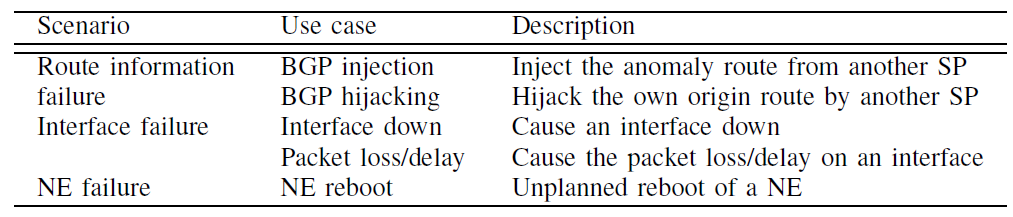


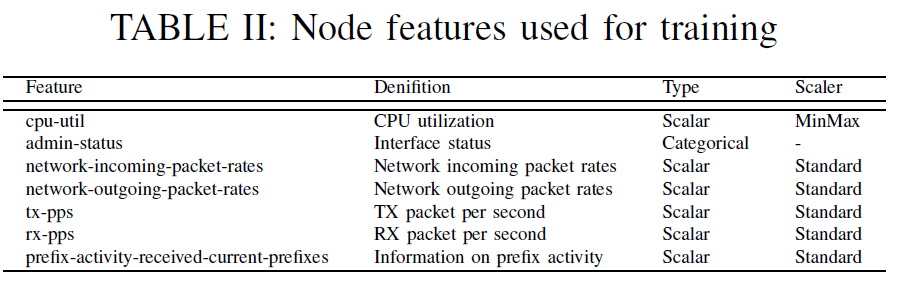


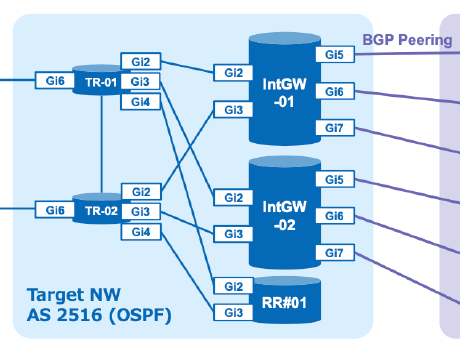

### Import libraries

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as mt
import time
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
np.set_printoptions(threshold=np.inf)

### Load NFV Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# Preprocessing the dataset
# ----------------------------------------------------------------------------------------------------------------------
data = pd.read_csv("/content/drive/MyDrive/NFV/train_dataset_with_node_localization.csv").reset_index(drop=True)

data['label'] = data['label'].replace(6,5)

target = pd.DataFrame()
target['label'] = data['label']
target['node'] = data['node']
target = target.fillna(0)
data = data.drop(columns=['node'])
data = data.astype(float)

In [ ]:
n_classes = len(target['label'].unique())

In [ ]:
#split data
print("Split data")
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1,random_state=42, stratify=target['label'], shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

X_val = X_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

Split data


In [ ]:
X_train.head(2)

,timestamp,admin-status_IntGW-01+link-intgw-exgw-a-1,admin-status_IntGW-01+link-intgw-exgw-a-2,admin-status_IntGW-01+link-intgw-exgw-a-3,admin-status_IntGW-01+link-tr-intgw-a-1,admin-status_IntGW-01+link-tr-intgw-b-1,admin-status_IntGW-02+link-intgw-exgw-b-1,admin-status_IntGW-02+link-intgw-exgw-b-2,admin-status_IntGW-02+link-intgw-exgw-b-3,admin-status_IntGW-02+link-tr-intgw-a-2,...,tx-pps_TR-01+link-tr-intgw-a-3,tx-pps_TR-01+link-tr-ssm-a-1,tx-pps_TR-01+link-tr-tr-a-1,tx-pps_TR-02+link-tr-intgw-b-1,tx-pps_TR-02+link-tr-intgw-b-2,tx-pps_TR-02+link-tr-intgw-b-3,tx-pps_TR-02+link-tr-ssm-b-1,tx-pps_TR-02+link-tr-tr-a-1,label,status
0,2.020063e+13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.080694,0.200580,-0.022388,0.084676,0.051722,-0.048757,0.226873,-0.02355,0.0,0.0
1,2.020070e+13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.080694,0.295804,-0.022388,0.042889,0.096556,-0.048757,0.136956,-0.02355,0.0,0.0


In [ ]:
X_train.shape, X_test.shape, X_val.shape

((4834, 124), (597, 124), (538, 124))

In [ ]:
len(data)

5969

In [ ]:
admin_columns = ['admin-status_IntGW-01+link-intgw-exgw-a-1',
'admin-status_IntGW-01+link-intgw-exgw-a-2',
'admin-status_IntGW-01+link-intgw-exgw-a-3',
'admin-status_IntGW-01+link-tr-intgw-a-1',
'admin-status_IntGW-01+link-tr-intgw-b-1',
'admin-status_IntGW-02+link-intgw-exgw-b-1',
'admin-status_IntGW-02+link-intgw-exgw-b-2',
'admin-status_IntGW-02+link-intgw-exgw-b-3',
'admin-status_IntGW-02+link-tr-intgw-a-2',
'admin-status_IntGW-02+link-tr-intgw-b-2',
'admin-status_RR-01+link-tr-intgw-a-3',
'admin-status_RR-01+link-tr-intgw-b-3',
'admin-status_TR-01+link-tr-intgw-a-1',
'admin-status_TR-01+link-tr-intgw-a-2',
'admin-status_TR-01+link-tr-intgw-a-3',
'admin-status_TR-01+link-tr-ssm-a-1',
'admin-status_TR-01+link-tr-tr-a-1',
'admin-status_TR-02+link-tr-intgw-b-1',
'admin-status_TR-02+link-tr-intgw-b-2',
'admin-status_TR-02+link-tr-intgw-b-3',
'admin-status_TR-02+link-tr-ssm-b-1',
'admin-status_TR-02+link-tr-tr-a-1']

INTGW_01_colmuns = ['cpu_util_IntGW-01',
'network-incoming-packets-rate_IntGW-01+link-intgw-exgw-a-1',
'network-incoming-packets-rate_IntGW-01+link-intgw-exgw-a-2',
'network-incoming-packets-rate_IntGW-01+link-intgw-exgw-a-3',
'network-incoming-packets-rate_IntGW-01+link-tr-intgw-a-1',
'network-incoming-packets-rate_IntGW-01+link-tr-intgw-b-1',
'network-outgoing-packets-rate_IntGW-01+link-intgw-exgw-a-1',
'network-outgoing-packets-rate_IntGW-01+link-intgw-exgw-a-2',
'network-outgoing-packets-rate_IntGW-01+link-intgw-exgw-a-3',
'network-outgoing-packets-rate_IntGW-01+link-tr-intgw-a-1',
'network-outgoing-packets-rate_IntGW-01+link-tr-intgw-b-1',
'prefix-activity-received-current-prefixes_IntGW-01_Gi5',
'prefix-activity-received-current-prefixes_IntGW-01_Gi6',
'prefix-activity-received-current-prefixes_IntGW-01_Gi7',
'rx-pps_IntGW-01+link-intgw-exgw-a-1',
'rx-pps_IntGW-01+link-intgw-exgw-a-2',
'rx-pps_IntGW-01+link-intgw-exgw-a-3',
'rx-pps_IntGW-01+link-tr-intgw-a-1',
'rx-pps_IntGW-01+link-tr-intgw-b-1',
'tx-pps_IntGW-01+link-intgw-exgw-a-1',
'tx-pps_IntGW-01+link-intgw-exgw-a-2',
'tx-pps_IntGW-01+link-intgw-exgw-a-3',
'tx-pps_IntGW-01+link-tr-intgw-a-1',
'tx-pps_IntGW-01+link-tr-intgw-b-1']

INTGW_02_colmuns = ['cpu_util_IntGW-02',
'network-incoming-packets-rate_IntGW-02+link-intgw-exgw-b-1',
'network-incoming-packets-rate_IntGW-02+link-intgw-exgw-b-2',
'network-incoming-packets-rate_IntGW-02+link-intgw-exgw-b-3',
'network-incoming-packets-rate_IntGW-02+link-tr-intgw-a-2',
'network-incoming-packets-rate_IntGW-02+link-tr-intgw-b-2',
'network-outgoing-packets-rate_IntGW-02+link-intgw-exgw-b-1',
'network-outgoing-packets-rate_IntGW-02+link-intgw-exgw-b-2',
'network-outgoing-packets-rate_IntGW-02+link-intgw-exgw-b-3',
'network-outgoing-packets-rate_IntGW-02+link-tr-intgw-a-2',
'network-outgoing-packets-rate_IntGW-02+link-tr-intgw-b-2',
'prefix-activity-received-current-prefixes_IntGW-02_Gi5',
'prefix-activity-received-current-prefixes_IntGW-02_Gi6',
'prefix-activity-received-current-prefixes_IntGW-02_Gi7',
'rx-pps_IntGW-02+link-intgw-exgw-b-1',
'rx-pps_IntGW-02+link-intgw-exgw-b-2',
'rx-pps_IntGW-02+link-intgw-exgw-b-3',
'rx-pps_IntGW-02+link-tr-intgw-a-2',
'rx-pps_IntGW-02+link-tr-intgw-b-2',
'tx-pps_IntGW-02+link-intgw-exgw-b-1',
'tx-pps_IntGW-02+link-intgw-exgw-b-2',
'tx-pps_IntGW-02+link-intgw-exgw-b-3',
'tx-pps_IntGW-02+link-tr-intgw-a-2',
'tx-pps_IntGW-02+link-tr-intgw-b-2'
]

RR_01_columns = ['cpu_util_RR-01',
'network-incoming-packets-rate_RR-01+link-tr-intgw-a-3',
'network-incoming-packets-rate_RR-01+link-tr-intgw-b-3',
'network-outgoing-packets-rate_RR-01+link-tr-intgw-a-3',
'network-outgoing-packets-rate_RR-01+link-tr-intgw-b-3',
'rx-pps_RR-01+link-tr-intgw-a-3',
'rx-pps_RR-01+link-tr-intgw-b-3',
'tx-pps_RR-01+link-tr-intgw-a-3',
'tx-pps_RR-01+link-tr-intgw-b-3'
]

TR_01_02_columns = ['cpu_util_TR-01',
'network-incoming-packets-rate_TR-01+link-tr-intgw-a-1',
'network-incoming-packets-rate_TR-01+link-tr-intgw-a-2',
'network-incoming-packets-rate_TR-01+link-tr-intgw-a-3',
'network-incoming-packets-rate_TR-01+link-tr-ssm-a-1',
'network-incoming-packets-rate_TR-01+link-tr-tr-a-1',
'network-outgoing-packets-rate_TR-01+link-tr-intgw-a-1',
'network-outgoing-packets-rate_TR-01+link-tr-intgw-a-2',
'network-outgoing-packets-rate_TR-01+link-tr-intgw-a-3',
'network-outgoing-packets-rate_TR-01+link-tr-ssm-a-1',
'network-outgoing-packets-rate_TR-01+link-tr-tr-a-1',
'rx-pps_TR-01+link-tr-intgw-a-1',
'rx-pps_TR-01+link-tr-intgw-a-2',
'rx-pps_TR-01+link-tr-intgw-a-3',
'rx-pps_TR-01+link-tr-ssm-a-1',
'rx-pps_TR-01+link-tr-tr-a-1',
'tx-pps_TR-01+link-tr-intgw-a-1',
'tx-pps_TR-01+link-tr-intgw-a-2',
'tx-pps_TR-01+link-tr-intgw-a-3',
'tx-pps_TR-01+link-tr-ssm-a-1',
'tx-pps_TR-01+link-tr-tr-a-1',
'cpu_util_TR-02',
'network-incoming-packets-rate_TR-02+link-tr-intgw-b-1',
'network-incoming-packets-rate_TR-02+link-tr-intgw-b-2',
'network-incoming-packets-rate_TR-02+link-tr-intgw-b-3',
'network-incoming-packets-rate_TR-02+link-tr-ssm-b-1',
'network-incoming-packets-rate_TR-02+link-tr-tr-a-1',
'network-outgoing-packets-rate_TR-02+link-tr-intgw-b-1',
'network-outgoing-packets-rate_TR-02+link-tr-intgw-b-2',
'network-outgoing-packets-rate_TR-02+link-tr-intgw-b-3',
'network-outgoing-packets-rate_TR-02+link-tr-ssm-b-1',
'network-outgoing-packets-rate_TR-02+link-tr-tr-a-1',
'rx-pps_TR-02+link-tr-intgw-b-1',
'rx-pps_TR-02+link-tr-intgw-b-2',
'rx-pps_TR-02+link-tr-intgw-b-3',
'rx-pps_TR-02+link-tr-ssm-b-1',
'rx-pps_TR-02+link-tr-tr-a-1',
'tx-pps_TR-02+link-tr-intgw-b-1',
'tx-pps_TR-02+link-tr-intgw-b-2',
'tx-pps_TR-02+link-tr-intgw-b-3',
'tx-pps_TR-02+link-tr-ssm-b-1',
'tx-pps_TR-02+link-tr-tr-a-1']

### Data Preparation For split

In [ ]:
batch_size = 128
class Distribute_NFV_Data:
    """
  This class distribute each row among different workers
  It returns a dictionary with key as data owner's id and
  value as a pointer to the list of data batches at owner's
  location.
  """

    def __init__(self, data_owners, data_df, target):

        self.batch_size = batch_size
        self.total_batches = int(len(data_df)/self.batch_size)
        #print(self.total_batches)

        #admin
        self.client1_data = data_df[admin_columns].reset_index(drop=True)  #admin features
        #INTGW-01
        self.client2_data = data_df[INTGW_01_colmuns].reset_index(drop=True)
        #INTGW-02
        self.client3_data = data_df[INTGW_02_colmuns].reset_index(drop=True)
        #RR-01
        self.client4_data = data_df[RR_01_columns].reset_index(drop=True)
        #TR-01 - TR02
        self.client5_data = data_df[TR_01_02_columns].reset_index(drop=True)

        self.data_owners = data_owners
        self.data_loader = data_df
        self.no_of_owner = len(data_owners)
        self.labels = []
        self.target = target['label'].values
        self.data_pointer = []
        clt1, clt2, clt3, clt4, clt5 = data_owners

        self.nodes = target['node'].values
        self.failure_nodes_label = []



       # iterate over each batch of data for, 1) spliting features 2) sending to VirtualWorker
        for batch in range(self.total_batches):
          b_client1, b_client2, b_client3,  b_client4, b_client5, labels_, nodes_ = self.get_batch(batch)

          curr_data_dict = {}

          self.labels.append(torch.tensor(labels_).float())
          #print(len(nodes_))
          self.failure_nodes_label.append(nodes_)

          client1_part_ptr = torch.tensor(np.copy(b_client1.values)).float().send(clt1)   #Sends tensor to the worker
          curr_data_dict[clt1.id] = torch.clone(client1_part_ptr)

          client2_part_ptr = torch.tensor(np.copy(b_client2.values)).float().send(clt2)
          curr_data_dict[clt2.id] = torch.clone(client2_part_ptr)

          client3_part_ptr = torch.tensor(np.copy(b_client3.values)).float().send(clt3)
          curr_data_dict[clt3.id] = torch.clone(client3_part_ptr)

          client4_part_ptr = torch.tensor(np.copy(b_client4.values)).float().send(clt4)
          curr_data_dict[clt4.id] = torch.clone(client4_part_ptr)

          client5_part_ptr = torch.tensor(np.copy(b_client5.values)).float().send(clt5)
          curr_data_dict[clt5.id] = torch.clone(client5_part_ptr)

          self.data_pointer.append(curr_data_dict)


    def __iter__(self):
      for data_ptr, label, node in zip(self.data_pointer[:-1], self.labels[:-1], self.failure_nodes_label[:-1]):
        yield (data_ptr, label, node)


    def __len__(self):
        return len(self.data_loader)-1


    def get_batch(self, batch_nb):
      batch_client1 = self.client1_data[self.batch_size*batch_nb : (self.batch_size* batch_nb + self.batch_size)]
      batch_client2 = self.client2_data[self.batch_size*batch_nb : (self.batch_size* batch_nb + self.batch_size)]
      batch_client3 = self.client3_data[self.batch_size*batch_nb : (self.batch_size* batch_nb + self.batch_size)]
      batch_client4 = self.client4_data[self.batch_size*batch_nb : (self.batch_size* batch_nb + self.batch_size)]
      batch_client5 = self.client5_data[self.batch_size*batch_nb : (self.batch_size* batch_nb + self.batch_size)]
      labels_ = self.target[self.batch_size*batch_nb : (self.batch_size* batch_nb + self.batch_size)]
      nodes_ = self.nodes[self.batch_size*batch_nb : (self.batch_size* batch_nb + self.batch_size)]

      return batch_client1, batch_client2, batch_client3, batch_client4, batch_client5, labels_, nodes_

### Split Learning Training Functions

In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import syft as sy
from torch.nn.utils import clip_grad_norm_

# we override methods on PyTorch tensors, meaning that extended functions on PyTorch tensors are made available
hook = sy.TorchHook(torch)    # A TorchHook object which is used to modify PyTorch with PySyft’s functionality.

In [ ]:
# create virutal workers
client_1 = sy.VirtualWorker(hook, id="client_1")   #known worker on a network which this worker may need to communicate with in the future. The key of each should be each worker’s unique ID
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")

client_4 = sy.VirtualWorker(hook, id="client_4")
client_5 = sy.VirtualWorker(hook, id="client_5")


server = sy.VirtualWorker(hook, id="server")

# we cannot make operations with tensors on different machines i.e. client_1 and client_2 --> TensorsNotCollocatedException
data_owners = (client_1, client_2, client_3, client_4, client_5)
model_locations = [client_1, client_2, client_3, client_4, client_5, server]

In [ ]:
# to check a worker’s objects
#client_1._objects

In [ ]:
y_train.head()

,label,node
0,0.0,0
1,0.0,0
2,0.0,0
3,5.0,TR-01
4,5.0,IntGW-02


In [ ]:
#Distribute Qot Data For Train - Test - Validtion Sets
distributed_trainloader = Distribute_NFV_Data(data_owners= (client_1, client_2, client_3, client_4, client_5), data_df=X_train, target=y_train)
distributed_testloader = Distribute_NFV_Data(data_owners= (client_1, client_2, client_3, client_4, client_5), data_df=X_test, target=y_test)
distributed_validloader = Distribute_NFV_Data(data_owners= (client_1, client_2, client_3, client_4, client_5), data_df=X_val, target=y_val)

In [ ]:
len(X_train), len(X_val), len(X_test)

(4834, 538, 597)

In [ ]:
distributed_trainloader.data_pointer[0]['client_1'].shape, distributed_trainloader.data_pointer[0]['client_2'].shape, distributed_trainloader.data_pointer[0]['client_3'].shape, distributed_trainloader.data_pointer[0]['client_4'].shape, distributed_trainloader.data_pointer[0]['client_5'].shape

(torch.Size([128, 22]),
 torch.Size([128, 24]),
 torch.Size([128, 24]),
 torch.Size([128, 9]),
 torch.Size([128, 42]))

### Split NN Models

In [ ]:
clt1_input = distributed_trainloader.data_pointer[0]['client_1'].shape[1]
clt2_input = distributed_trainloader.data_pointer[0]['client_2'].shape[1]
clt3_input = distributed_trainloader.data_pointer[0]['client_3'].shape[1]
clt4_input = distributed_trainloader.data_pointer[0]['client_4'].shape[1]
clt5_input = distributed_trainloader.data_pointer[0]['client_5'].shape[1]


input_size= [clt1_input, clt2_input, clt3_input, clt4_input, clt5_input]
merging_technique = 'concat'  # concat, sum, average, max, product
# server layers should be changed accordingly to the merging technique
hidden_sizes= {"client_1": [32, 48, 64], "client_2":[32, 48, 64], "client_3":[32, 48, 64], "client_4": [32, 48, 64], "client_5":[32, 48, 64], "server":[64 * 5, 64]}

# clients architecture can be varied
#create model segment for each worker
models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                #nn.BatchNorm1d(hidden_sizes["client_1"][0]),
                #nn.Dropout(p=0.2),
                nn.ReLU(),
                #nn.GELU(),

                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_1"][1]),
                #nn.Dropout(p=0.2),
                nn.ReLU(),
                #nn.GELU(),

                #nn.Linear(hidden_sizes["client_1"][1], hidden_sizes["client_1"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_1"][2]),
                #nn.Dropout(p=0.2),
                #nn.ReLU(),

    ),
    "client_2": nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                #nn.BatchNorm1d(hidden_sizes["client_2"][0]),
                #nn.Dropout(p=0.2),
                nn.ReLU(),
                #nn.GELU(),

                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_2"][1]),
                #nn.Dropout(p=0.2),
                nn.ReLU(),
                #nn.GELU(),

                #nn.Linear(hidden_sizes["client_2"][1], hidden_sizes["client_2"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_2"][2]),
                #nn.Dropout(p=0.2),
                #nn.ReLU(),
    ),
    "client_3": nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                #nn.BatchNorm1d(hidden_sizes["client_3"][0]),
                #nn.Dropout(p=0.2),
                nn.ReLU(),
                #nn.GELU(),

                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_3"][1]),
                #nn.Dropout(p=0.2),
                #nn.GELU(),
                nn.ReLU(),

                #nn.Linear(hidden_sizes["client_3"][1], hidden_sizes["client_3"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_3"][2]),
                #nn.Dropout(p=0.2),
                #nn.ReLU(),
    ),
    "client_4": nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                #nn.BatchNorm1d(hidden_sizes["client_4"][0]),
                #nn.Dropout(p=0.2),
                nn.ReLU(),
                #nn.GELU(),

                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_4"][1]),
                #nn.Dropout(p=0.2),
                nn.ReLU(),
                #nn.GELU(),

                #nn.Linear(hidden_sizes["client_4"][1], hidden_sizes["client_4"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_4"][2]),
                #nn.Dropout(p=0.2),
                #nn.ReLU(),
    ),
    "client_5": nn.Sequential(
                nn.Linear(input_size[4], hidden_sizes["client_5"][0]),
                #nn.BatchNorm1d(hidden_sizes["client_5"][0]),
                #nn.Dropout(p=0.2),
                #nn.GELU(),
                nn.ReLU(),

                nn.Linear(hidden_sizes["client_5"][0], hidden_sizes["client_5"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_5"][1]),
                #nn.Dropout(p=0.2),
                #nn.GELU(),
                nn.ReLU(),

                #nn.Linear(hidden_sizes["client_5"][1], hidden_sizes["client_5"][2]),
                #nn.BatchNorm1d(hidden_sizes["client_5"][2]),
                #nn.Dropout(p=0.2),
                #nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                #nn.BatchNorm1d(hidden_sizes["server"][1]),
                #nn.Dropout(p=0.2),
                #nn.GELU(),
                nn.ReLU(),

                #nn.Linear(hidden_sizes["server"][1], hidden_sizes["server"][2]),
                #nn.BatchNorm1d(hidden_sizes["server"][2]),
                #nn.Dropout(p=0.2),
                #nn.GELU(),

                nn.Linear(hidden_sizes["server"][1], n_classes),
                #nn.Softmax(dim=1)
                nn.LogSoftmax(dim=1)
    )
}

In [ ]:
# Create optimisers for each segment and link to their segment
learning_rate = 0.05
optimizers = [
    optim.Adam(models[location.id].parameters(), lr=learning_rate,)
    #optim.SGD(models[location.id].parameters(), lr = learning_rate,)
    for location in model_locations
]

#send model segement to each client and server
for location in model_locations:
    models[location.id].send(location)

In [ ]:
def eltWiseMaxPooling(elts):
  return np.max(elts, axis=0)

def averagePooling(elts):
  return np.mean(elts, axis=0)

def sumPooling(elts):
  return np.sum(elts, axis=0)

def eltWiseProduct(elts):
  return np.prod(elts, axis=0)

def concatenation(elts):
  return torch.cat(elts, 1)

def mergingTechnique(elts, technique='concat'):
  if technique == 'sum':
    return sumPooling(elts)

  if technique == 'average':
    return averagePooling(elts)

  if technique == 'product':
    return eltWiseProduct(elts)

  if technique == 'max':
    return eltWiseMaxPooling(elts)

  if technique == 'concat':
    return concatenation(elts)

  print("--> ERROR MERGING TECHNIQUE DO NOT EXIST")
  return "--> ERROR MERGING TECHNIQUE DO NOT EXIST"

In [ ]:
def predict(data_pointer, models, data_owners, server):
    #individual client's output upto their respective cut layer
    client_output = {}

    #outputs that is moved to server and subjected to concatenate for server input
    remote_outputs = []

    #iterate over each client and pass thier inputs to respective model segment and send outputs to server
    for owner in data_owners:
        client_output[owner.id] = models[owner.id](data_pointer[owner.id])
        remote_outputs.append(
            client_output[owner.id].move(server)
        )

    if merging_technique == 'concat':
      server_input = mergingTechnique(remote_outputs, 'concat')
    else:
      server_input = []
      for i in range(len(remote_outputs)):
        remote_outputs[i] = remote_outputs[i].get()
      for i in range(batch_size):
        row = tuple()
        for j in range(len(remote_outputs)):
          row += tuple([remote_outputs[j][i].detach().numpy()])
        server_input.append(mergingTechnique(row, merging_technique))
      server_input = torch.tensor(server_input)
      server_input = server_input.send(server)

    #pass output from server's model segment
    pred = models["server"](server_input)
    return pred

In [ ]:
def accuracy(y_pred, y_test):
  _, pred = y_pred.get().max(dim=1)
  return mt.accuracy_score(y_test.get(), pred)

In [ ]:
def train(data_pointer, target, data_owners, models, optimizers, server):

    #make grads zero
    for opt in optimizers:
        opt.zero_grad()

    #predict the output
    pred = predict(data_pointer, models, data_owners, server)

    #calculate loss
    criterion = nn.NLLLoss()
    #criterion = nn.CrossEntropyLoss()
    loss = criterion(pred, target.reshape(-1, batch_size)[0].type(torch.LongTensor))

    # accuracy
    acc = accuracy(pred, target)

    #backpropagate
    loss.backward()

    #optimization step
    for opt in optimizers:
        opt.step()

    return loss.detach().get(), acc #acc.detach().get()

In [ ]:
def mean(values):
    return sum(values) / len(values)

In [ ]:
print(torch.__version__)

1.4.0


### Start Training

In [ ]:
train_hist_loss = []
train_hist_accuracies= []

validation_hist_accuracies = []
validation_hist_loss = []

#training
epochs = 25
for i in range(epochs):
    running_loss = 0
    batch_counter = 0
    training_acc = []

    #iterate over each training datapoints
    for data_ptr, label, node in distributed_trainloader:
        #send labels to server's location for training
        label = label.send(server)
        loss, acc = train(data_ptr, label, data_owners, models, optimizers, server)
        running_loss += loss
        training_acc.append(acc)

        #if batch_counter%50 ==0:
        #print("Epoch: "+str(i) + " Batch: " + str(batch_counter) + " Acc: " + str(acc))
        batch_counter += 1

    train_hist_accuracies.append(mean(training_acc))
    train_hist_loss.append(running_loss)

    print("---> Epoch {} - Training loss: {}".format(i, running_loss))
    print("---> Epoch {} - Training Accuracy: {}".format(i, acc))

    # Validation Step over the distributed_valid_loader
    # Prediction on validation Set
    # validation_acc, validation_loss = test(models, distributed_validloader, "Validation Set")
    # Saving the history
    validation_running_loss = 0
    validation_acc = []
    for data_ptr, label, node in distributed_validloader:
        label = label.send(server)
        pred  = predict(data_ptr, models, data_owners, server)
        criterion = nn.NLLLoss()
        #criterion = nn.CrossEntropyLoss()
        validation_loss = criterion(pred, label.reshape(-1, batch_size)[0].type(torch.LongTensor))
        validation_loss = validation_loss.detach().get()

        validation_acc.append(accuracy(pred, label))
        validation_running_loss+=validation_loss

    validation_hist_accuracies.append(mean(validation_acc))  # mean because mean over batches
    validation_hist_loss.append(validation_running_loss)  # sum because of batches we have to cumulate the sum

    print("---> Epoch {} - Validation loss: {}".format(i, validation_running_loss))
    print("---> Epoch {} - Validation Accuracy: {}".format(i, mean(validation_acc)))

              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90       237
         1.0       1.00      0.71      0.83         7
         2.0       1.00      0.36      0.53        11
         3.0       0.75      1.00      0.86         3
         4.0       0.95      0.95      0.95        19
         5.0       0.92      0.63      0.74       107

    accuracy                           0.86       384
   macro avg       0.91      0.77      0.80       384
weighted avg       0.87      0.86      0.85       384



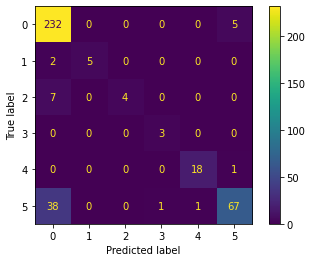

In [ ]:
# Test Performance
all_test_preds = []
all_test_labels = []

with torch.no_grad():
  for data_ptr, label, node in distributed_testloader:
    pred = predict(data_ptr, models, data_owners, server).get()  # get a tensor from a worker
    _, y_pred_tag = pred.max(dim=1)
    for i in range(len(label)):
      all_test_preds.append(y_pred_tag[i])
      all_test_labels.append(label[i])

print(mt.classification_report(all_test_labels, all_test_preds))

confusion_matrix = mt.confusion_matrix(all_test_labels, all_test_preds)
cm_display = mt.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90      3365
         1.0       1.00      0.61      0.76       361
         2.0       0.90      0.36      0.51       312
         3.0       1.00      0.90      0.95       136
         4.0       0.81      0.85      0.83       153
         5.0       0.90      0.59      0.71       793

    accuracy                           0.85      5120
   macro avg       0.91      0.72      0.78      5120
weighted avg       0.86      0.85      0.84      5120



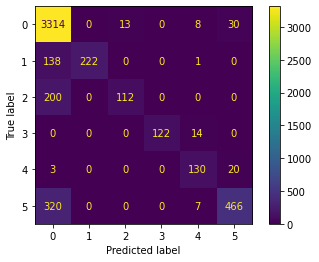

In [ ]:
# Test Performance
'''
all_test_preds = []
all_test_labels = []

with torch.no_grad():
  for data_ptr, label, node in distributed_data2_loader:
    pred = predict(data_ptr, models, data_owners, server).get()  # get a tensor from a worker
    _, y_pred_tag = pred.max(dim=1)
    for i in range(len(label)):
      all_test_preds.append(y_pred_tag[i])
      all_test_labels.append(label[i])

print(mt.classification_report(all_test_labels, all_test_preds))

confusion_matrix = mt.confusion_matrix(all_test_labels, all_test_preds)
cm_display = mt.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()
'''

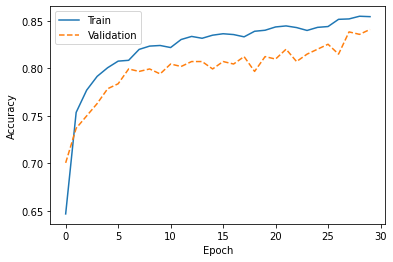

In [ ]:
plt.plot(np.arange(0, epochs, 1/int(len(train_hist_accuracies)/epochs)), train_hist_accuracies, label='Train' )
plt.plot(np.arange(epochs), validation_hist_accuracies, ls='--', label='Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

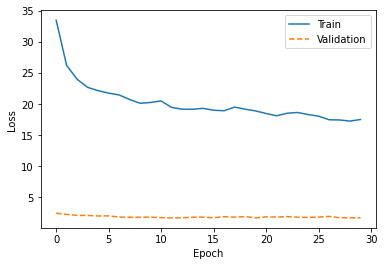

In [ ]:
plt.plot(np.arange(0, epochs, 1/int(len(train_hist_loss)/epochs)), train_hist_loss, label='Train')
plt.plot(np.arange(epochs), validation_hist_loss, ls='--', label='Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()